Obtención de los datos

In [ ]:
import pandas as pd

# Cargar datos
path='C:/4_F5/011_proyecto_ml/'


df = pd.read_csv(path + '/airline_passenger_satisfaction.csv')

#Se elimina la primera columna que era el subíndice del csv
df = df.iloc[:, 1:] 
df=df.drop(columns='id') #no sé si al final quito el id porque me estorba

In [ ]:
#Hay que crear una parte que sea 'test'
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=22 )

# test_size=0.2, este parámetro indica que deseas que el 20% de los datos se utilicen como conjunto de prueba y el 80% como conjunto de entrenamiento. 
# random_state=22 Este parámetro establece una semilla para el generador de números aleatorios que se usa para realizar la división. Esto asegura que cada vez que ejecutes el código, obtendrás la misma división de los datos en conjuntos de entrenamiento y prueba. Usar un valor de random_state fijo es una buena práctica cuando quieres que tus resultados sean reproducibles.

train.to_csv(path+'df_train.csv', index=False)
test.to_csv(path+'df_test.csv', index=False)
#Este test no lo tocamos hasta el final

3. Exploración y visualización de Datos

In [ ]:
print(df.info())

In [ ]:
print(f'\n\nEl DF tiene {df.shape[0]:,} filas')
print(f'El DF tiene {df.shape[1]} columnas')

Voy a tratar los missings

In [ ]:
# Comprobar cuántos valores missing existen en el DataFrame por variable

nulos={'conteo_nulos':df.isnull().sum(),'proporcion%':round(df.isnull().sum()/df.shape[0]*100, 3)}

df_nulos=pd.DataFrame(data=nulos)
print(df_nulos)

Antes de convertir las variables hay que tratar los 'missings'.

Que según hemos concluido, tantos los valores '0' como los 'espacios en blanco' son 'missing' y los vamos a eliminar. ---->Al final hemos decidido que los '0' sí se van a tener en cuenta.

In [ ]:
# Primero elimino los 'missings'
df = df.dropna(how='any')

print(f'\n\nEl DF tiene {df.shape[0]:,} filas')


# Compruebo que se ha eliminado
missing={'conteo_nulos':df.isnull().sum(),'proporcion%':round(df.isnull().sum()/df.shape[0]*100, 3)}
df_coun_missing=pd.DataFrame(data=nulos)
print(df_coun_missing)

Separo la Variable Objetivo, 'Y', de las Variables predictoras 'X'

In [ ]:
#En este dataframe guarda la variable Objetivo, 'Y'
y = df['satisfaction']

In [ ]:
#En esta dataframe 'x' se guardan las variables predictoras
x=df.drop(columns=['satisfaction'])

print(f'Las variables son {len(x.columns)}:\n\n' + '\n'.join(x.columns) + '\n')


Codifico 'Y' en binario, aunque a veces hay modelos que trabajan igualmente bien sin codificar.

In [ ]:
# Codificación de la variable objetivo

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_le = le.fit_transform(y)


In [ ]:
# Conteo de los valores por cada columna ----> Hacer bucle para ver si hay columnas que estén desbalanceadas.
# Para ver qué variables hay que escalar

df['Customer Type'].value_counts()

In [ ]:
#Ahora elimino los '0' pero de las columnas categóricas ordinales
# -->Ya no, hemos decidido dejarlos !!!!!!



Voy a separar las variables, por un lado según sean categóricas(binarias, ordinales..) y por otro las numéricas

· Categóricas

· Numéricas

Porque a veces un modelo va a trabajar mejor sólo con las categóricas o sólo con las numéricas.
Además, es conveniente escalar las variables munéricas (ya sean por cambios de escala o por magnitud, o incluso 'normalizarlas')

Detecto las variables categóricas para separarlas de las numéricas, porque es conveniente para codificar tanto las categóricas ordinales(que en este caso no es necesario porque ya están del 0 al 5) y las categóricas binarias, por un lado, y escalar las numéricas.

Filtro en el dataframe 'X' las variables categóricas y las variables numéricas.

In [ ]:
import pandas as pd
from pandas.api.types import is_categorical_dtype

# Para detectar me da igual usar 'X' o usar 'X_TRAIN' porque sólo quiero el nombre de las columans
# Función para detectar variables categóricas ordinales
def detectar_variables_ordinales(x):
    ordinal_columns = []

    for column in x.columns:
        # verificar si la columna es numérica
        if pd.api.types.is_numeric_dtype(x[column]):
            # obtener valores únicos
            unique_values = x[column].unique()
            # verificar si todos los valores están en el rango [1,5]
            if set(unique_values).issubset({0, 1, 2, 3, 4, 5}):
                ordinal_columns.append(column)

    
    return ordinal_columns




variables_ordinales = detectar_variables_ordinales(x)

print(f'Variables categóricas ordinales: {len(variables_ordinales)}\n\n' + '\n'.join(variables_ordinales) + '\n')


# Resultado:
# Variables categóricas ordinales: ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
# Ya no !!!!!  ----> De esas variables hay que quitar los '0' porque hemos decidido que son missing. Antes de hacer el one-hot-encoding


In [ ]:
# Variables que son categóricas binarias y categóricas no ordinales
import pandas as pd

def detectar_variables_categoricas(x):
    categorias_columns = []

    for column in x.columns:
        # Verificar si la columna no es numérica
        if not pd.api.types.is_numeric_dtype(x[column]):
            # Obtener el número de categorías únicas
            unique_values = x[column].nunique()
            # Se puede agregar un límite arbitrario si se desea,
            # por ejemplo, menos de 10 categorías únicas
            if unique_values < 10:
                categorias_columns.append(column)

    return categorias_columns

# Supongamos que tienes un DataFrame df
variables_categoricas = detectar_variables_categoricas(x)

print(f'Variables categóricas binarias y categóricas no ordinales: {len(variables_categoricas)}\n\n' + '\n'.join(variables_categoricas) + '\n')


Junto el nombre de las variables categóricas (ya sean binarias, no ordinales y ordinales)

In [ ]:
#Filtro para quedarme con las numéricas, las que voy a escalar

# Primero detecto las columnas que tienen solo valores de 0 y 1
""" binary_cols = x_encoded.columns[x_encoded.nunique() == 2]

# Luego detecto las columnas ordinales (2 a 5)
ordinal_cols = x_encoded.columns[(x_encoded.nunique() > 1) & (x_encoded.nunique() <= 5)] """

# Ambas categóricas las junto 
categorical_cols = list(variables_categoricas) + list(variables_ordinales)



print(f'Variables categóricas en total: {len(categorical_cols)}\n\n' + '\n'.join(categorical_cols) + '\n')


Ahora encuentro las variables numéricas y las filtro

In [ ]:
data_cat=x[categorical_cols]
data_num=x.drop(columns=categorical_cols)

print(f'Variables numéricas: {len(data_num.columns)}\n\n' + '\n'.join(data_num.columns) + '\n')


Ahora hay que sacar el 'train' y 'test' tanto de 'Y' como de 'X'

In [ ]:
# Separa el dataframe en partes de entrenamiento y prueba, tanto en 'X' como en 'Y'
x_train, x_test, y_train, y_test = train_test_split(x, y_le, test_size=0.3, random_state=42)


**One-Hot Encoding es generalmente preferido cuando no hay un orden inherente en las categorías. De esta manera, me aseguro de que el modelo no asuma relaciones incorrectas entre las categorías.

**Label Encoding podría usarse si hay un orden claro entre las categorías.
Cuando tienes un DataFrame con columnas categóricas y categóricas ordinales, es importante elegir el método de codificación adecuado que preserve la naturaleza ordinal de la columna.

Primero se debe usar OrdinalEncoder a las variables originales y luego OneHotENcoder (en nuestro caso por cómo está codificado las variable ordinales no hace falta) 

In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# 2. Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), data_num.columns),
        ('cat', OneHotEncoder(), variables_categoricas) #Usamos drop='first' en OneHotEncoder para evitar la trampa de las variables dummy.
    ],
    remainder='passthrough')


In [73]:
# 3. Ajustar y transformar los datos de entrenamiento
x_train_processed = preprocessor.fit_transform(x_train)

# 4. Transformar los datos de prueba
x_test_processed = preprocessor.transform(x_test)

# 5. Convertir a DataFrames de pandas
# Obtenemos los nombres de las columnas después del preprocesamiento
onehot_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = onehot_encoder.get_feature_names_out(variables_categoricas) #Este método ahora genera nombres de características de salida después de aplicar el One-Hot Encoding. Asegúrate de que categorical_cols contenga las columnas que se codificarán.
feature_names = list(data_num.columns) + list(cat_feature_names)+list(variables_ordinales)
#print(feature_names)

print(cat_feature_names)
print(len(cat_feature_names))


print(feature_names)
print(len(feature_names))

['Gender_Female' 'Gender_Male' 'Customer Type_Loyal Customer'
 'Customer Type_disloyal Customer' 'Type of Travel_Business travel'
 'Type of Travel_Personal Travel' 'Class_Business' 'Class_Eco'
 'Class_Eco Plus']
9
['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Gender_Female', 'Gender_Male', 'Customer Type_Loyal Customer', 'Customer Type_disloyal Customer', 'Type of Travel_Business travel', 'Type of Travel_Personal Travel', 'Class_Business', 'Class_Eco', 'Class_Eco Plus', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
27


In [74]:
x_train_processed_df = pd.DataFrame(x_train_processed, columns=feature_names,index=x_train.index)
x_test_processed_df = pd.DataFrame(x_test_processed, columns=feature_names, index=x_test.index)

x_test_processed_df

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
18595,1.761639,-0.865809,-0.387271,-0.392586,1.0,0.0,1.0,0.0,1.0,0.0,...,2.0,4.0,1.0,5.0,5.0,5.0,5.0,2.0,5.0,3.0
19336,-1.083807,-0.047478,-0.387271,-0.392586,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,2.0,1.0,1.0,4.0,3.0,4.0,4.0,5.0,1.0
72501,-0.554422,-0.882858,-0.387271,-0.392586,1.0,0.0,1.0,0.0,0.0,1.0,...,5.0,1.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,5.0
85210,0.702868,-0.396472,2.104466,1.663422,1.0,0.0,1.0,0.0,1.0,0.0,...,4.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0
87824,-0.355902,-1.049332,-0.387271,-0.392586,0.0,1.0,1.0,0.0,1.0,0.0,...,4.0,4.0,4.0,4.0,3.0,2.0,4.0,2.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73004,-1.414673,1.289330,-0.387271,-0.392586,0.0,1.0,1.0,0.0,0.0,1.0,...,2.0,1.0,1.0,5.0,2.0,5.0,5.0,1.0,4.0,1.0
17946,0.636695,1.381593,0.805582,0.648431,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,1.0
100824,-1.745539,-0.103638,-0.387271,-0.340535,1.0,0.0,0.0,1.0,1.0,0.0,...,3.0,2.0,3.0,3.0,1.0,1.0,5.0,2.0,3.0,3.0
52391,1.298427,1.370561,-0.387271,-0.392586,1.0,0.0,1.0,0.0,1.0,0.0,...,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0


In [ ]:

""" 
# Variables categóricas ordinales -----> no haría falta
# Crear OrdinalEncoder
encoder_ord = OrdinalEncoder()
# Aplicar OrdinalEncoder a múltiples variables categóricas ordinales.
# Machaco la variable x_train_cat que la recojo de la codificación anterior.
x_train_ord_encod= pd.DataFrame(encoder_ord.fit_transform(x_train_cat_encod), columns=x_train_cat_encod.columns)

#Hay que aplicar la transformación a la parte 'test'
x_test_ord_encod=pd.DataFrame(encoder_ord.transform(x_test_cat_encod), columns=x_test_cat_encod.columns)

# Concatenar la columna 'satisfaccion' de nuevo al DataFrame codificado
"""


¿Por qué este orden es importante?

Consistencia: Al separar primero X e y y luego hacer el split, garantizas que las filas correspondientes de X e y coincidan exactamente en los conjuntos de entrenamiento y prueba.

Evitar filtraciones de datos: Si haces el split antes de separar X e y, podrías accidentalmente introducir fugas de datos o inconsistencias, lo que podría afectar la capacidad del modelo para generalizar.

* Primero separas la 'y' de las variables predictoras 'x'.
* Luego El split de tanto 'y' como 'x' con su correspondiente 'train' y 'test'
* Finalmente voy a escalar las numéricas: Después de realizar el split, ajustas el escalador (Scaler) solo con el conjunto de entrenamiento (X_train). Esto asegura que las estadísticas de escalado (media, desviación estándar, etc.) no estén influenciadas por los datos de prueba.
* Aplicar la transformación de escalado al conjunto de prueba:Una vez que el escalador se ha ajustado al conjunto de entrenamiento, usas ese mismo escalador para transformar el conjunto de prueba (X_test). Esto asegura que ambos conjuntos sean escalados de manera consistente


In [ ]:
#Primero separas la 'y' de las variables predictoras 'x'
#Luego El split de tanto 'y' como 'x' con su correspondiente 'train' y 'test'
#Finalmente voy a escalar las numéricas: Después de realizar el split, ajustas el escalador (Scaler) solo con el conjunto de entrenamiento (X_train). Esto asegura que las estadísticas de escalado (media, desviación estándar, etc.) no estén influenciadas por los datos de prueba.
#Aplicar la transformación de escalado al conjunto de prueba:Una vez que el escalador se ha ajustado al conjunto de entrenamiento, usas ese mismo escalador para transformar el conjunto de prueba (X_test). Esto asegura que ambos conjuntos sean escalados de manera consistente



La razón es que, en general, deseas mantener la separación entre los datos de entrenamiento y los datos de prueba, incluso después de la escalado. De esta manera, puedes asegurarte de que el modelo de machine learning se entrena y se evalúa correctamente.

In [ ]:

# En 'train' cojo las columnas numéricas sin escalar y las reemplazo con las columnas numéricas escaladas. 
# Por lo que ya me queda todo 'x_train' junto y escalado
#x_train[data_num.columns] = x_train_num_scaled


x_train.to_csv(path +   '/x_train_scaled.csv')

# En 'test' cojo las columnas numéricas sin escalar y las reemplazo con las columnas numéricas escaladas.
# Por lo que ya me queda todo 'x_test' junto y escalado

x_test.to_csv(path + '/x_test_scaled.csv')



In [ ]:
# Guardar datos en ficheros
""" 
path='C:/4_F5/011_proyecto_ml/'
pd.DataFrame(x_train_scaled).to_csv('x_train_scaled.csv', index=False)
pd.DataFrame(x_test_scaled).to_csv('x_test_scaled.csv', index=False)
y_train.to_csv(path + '/y_train.csv')
y_test.to_csv(path + '/y_test.csv')

 """

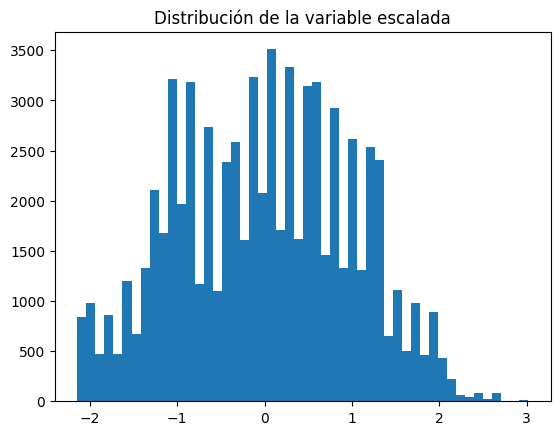

In [75]:
import matplotlib.pyplot as plt

# Histograma de la variable escalada
plt.hist(x_train_processed_df['Age'], bins=50)
plt.title('Distribución de la variable escalada')
plt.show()

# Histograma de la variable no escalada ---> usar de A´ngel


In [78]:
print('Estadísticas descriptivas de la variable escalada:')
print(x_train_processed_df['Age'].describe())

print('Estadísticas descriptivas de la variable escalada:')
#print(x_test_scaled[:, 0]).describe()) 

Estadísticas descriptivas de la variable escalada:
count    7.251500e+04
mean     7.446907e-18
std      1.000007e+00
min     -2.142578e+00
25%     -8.191147e-01
50%      4.113660e-02
75%      7.690415e-01
max      3.018930e+00
Name: Age, dtype: float64
Estadísticas descriptivas de la variable escalada:


In [ ]:
import matplotlib.pyplot as plt

# Histograma de la variable escalada
plt.hist(x_train_processed_df['Age'], bins=50)
plt.title('Distribución de la variable escalada')
plt.show()

# Histograma de la variable no escalada ---> usar de A´ngel

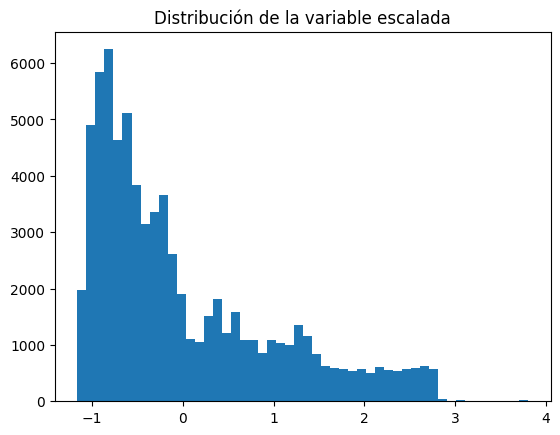

In [80]:
import matplotlib.pyplot as plt

# Histograma de la variable escalada
plt.hist(x_train_processed_df['Flight Distance'], bins=50)
plt.title('Distribución de la variable escalada')
plt.show()

# Histograma de la variable no escalada ---> usar de A´ngel

In [81]:
print(x_train_processed_df['Flight Distance'].describe())


count    7.251500e+04
mean     1.469784e-18
std      1.000007e+00
min     -1.161652e+00
25%     -7.775579e-01
50%     -3.463295e-01
75%      5.512274e-01
max      3.804495e+00
Name: Flight Distance, dtype: float64


## Primer modelo: Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Crea un objeto RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrena el modelo con el conjunto de entrenamiento
model.fit(x_train_processed_df, y_train)

# Evalúa el modelo con el conjunto de 'test'
y_pred = model.predict(x_test_processed_df)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9621609446893401


Para verificar si hay overfitting menor al 5% en el modelo de Random Forest, hay que comparar las métricas de rendimiento entre los conjuntos de 'train' y 'test'. 
Esto se hace calculando la precisión (accuracy) en ambos conjuntos, 'train' y 'test'. 
Si la diferencia entre ambas precisiones es mayor al 5%, hay un indicio de overfitting.

Pasos para calcular la diferencia en rendimiento:
* Calcula la precisión en el conjunto de entrenamiento.
* Calcula la precisión en el conjunto de prueba.
* Compara la diferencia entre ambas precisiones.

Si la diferencia es menor al 5%, entonces el modelo no sufre de un sobreajuste significativo.

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Crea un objeto RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               max_depth=10,  # Limita la profundidad de los árboles
                               max_features='sqrt') # Limita las características a considerar por nodo

#Tuve que añadirle dos hyperparámetros porque train_accuracy daba un 1.000, lo cual indicaba sobreajuste
#max_features='sqrt',  # Limita las características a considerar por nodo
#max_depth=10

# Entrena el modelo con el conjunto de entrenamiento
model.fit(x_train_processed_df, y_train)

# Predicción en el conjunto de entrenamiento
y_train_pred = model.predict(x_train_processed_df)

# Evaluación
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predicción en el conjunto de prueba
y_test_pred = model.predict(x_test_processed_df)

#Evaluación 
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcula la diferencia de precisión entre entrenamiento y prueba
accuracy_difference = abs(train_accuracy - test_accuracy)

# Imprime los resultados
print(f"Precisión en entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Diferencia de precisión (overfitting): {accuracy_difference:.4f}")

# Verifica si la diferencia es menor al 5%
if accuracy_difference <= 0.05:
    print("El modelo tiene un overfitting menor al 5%.")
else:
    print("El modelo tiene un overfitting mayor al 5%.")
    
from sklearn.metrics import confusion_matrix
#
# Generar la matriz de confusión
matrix_rf = confusion_matrix(y_test, y_test_pred)

print(f"\nMatriz de Confusión de Random Forest:\n{matrix_rf}")


Precisión en entrenamiento: 0.9511
Precisión en prueba: 0.9466
Diferencia de precisión (overfitting): 0.0045
El modelo tiene un overfitting menor al 5%.

Matriz de Confusión de Random Forest:
[[16863   720]
 [  940 12556]]


En la propia celda he corregido el sobreajuste

Precisión del 100% en entrenamiento es generalmente una señal de sobreajuste (overfitting), especialmente en modelos complejos como los Random Forests que pueden ajustarse perfectamente a los datos de entrenamiento. 

En el caso de Random Forest, el modelo podría haber memorizado los datos de entrenamiento, lo que explica por qué obtiene una precisión perfecta en ese conjunto.
Aunque la diferencia de precisión era menor al 5% (0.0378), el sobreajuste sigue siendo una preocupación porque:
* Random Forest puede ajustarse bien a los datos de entrenamiento debido a su flexibilidad, pero esto no siempre generaliza bien en nuevos datos (conjunto de prueba).
* Precisión del 100% en entrenamiento puede sugerir que el modelo ha aprendido "ruido" o patrones muy específicos de los datos de entrenamiento que no son aplicables a nuevos datos.

Posibles causas del overfitting:
* Modelo muy complejo: Random Forest puede tener muchos árboles o una profundidad excesiva en los árboles, lo que provoca un ajuste excesivo.
* Datos insuficientes: Si los datos no son lo suficientemente variados, el modelo puede "memorizar" los datos en lugar de aprender patrones generales.

Soluciones para reducir el sobreajuste:
* Reducir la complejidad del modelo: Ajusta los parámetros del Random Forest, como disminuir la profundidad máxima de los árboles (max_depth) o el número máximo de hojas (max_leaf_nodes). ----> usé esta
* Usar regularización: Limitar el número de características a considerar en cada nodo (max_features).
* Aumentar los datos: Más datos de entrenamiento pueden ayudar al modelo a generalizar mejor.
* Cross-validation:
Usar validación cruzada para evaluar cómo se comporta el modelo en diferentes particiones de los datos, en lugar de confiar en una única división entrenamiento/prueba.

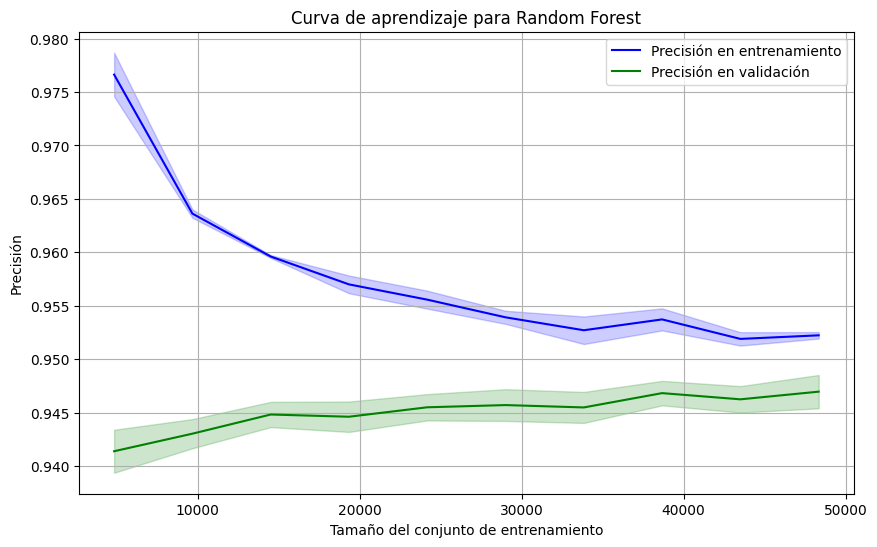

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


# Parámetros para la función learning_curve
train_sizes = np.linspace(0.1, 1.0, 10)  # Fracciones del conjunto de datos de entrenamiento que se usarán

# Generar curva de aprendizaje
train_sizes, train_scores, validation_scores = learning_curve(
    model, 
    x_train_processed_df, y_train, 
    train_sizes=train_sizes, 
    cv=3,  # Validación cruzada de 5 folds
    scoring='accuracy',  # Medimos la precisión del modelo
    n_jobs=-1  # Usar todos los núcleos disponibles,
)

# Cálculo de la media y desviación estándar para la precisión de entrenamiento y validación
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Precisión en entrenamiento', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.plot(train_sizes, validation_scores_mean, label='Precisión en validación', color='green')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='green', alpha=0.2)

# Etiquetas y leyenda
plt.title('Curva de aprendizaje para Random Forest')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.legend(loc='best')

# Mostrar gráfico
plt.grid()
plt.show()


Esto son métricas

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# ...

y_pred = model.predict(x_test)

# Calcula la accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Calcula la precisión (average='weighted' for multi-class problems)
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Calcula el recall
recall = recall_score(y_test, y_pred, average='weighted',labels=['neutral or dissatisfied', 'satisfied'])
print("Recall:", recall)

""" # Calcula el F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Calcula el ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", roc_auc)

# Calcula la matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat) """

Multicolinealidad

Probando 

In [ ]:

""" 
El problema es que el modelo de regresión lineal (LinearRegression) no entiende que tu variable objetivo es binaria.

La regresión lineal es un algoritmo de aprendizaje automático que se utiliza para predecir valores continuos, no binarios. 
Cuando entrenas el modelo con tus datos, el algoritmo intenta encontrar la mejor línea que se ajuste a tus datos, pero no 
tiene en cuenta que la variable objetivo es binaria.

Por lo tanto, cuando haces print(lin_reg.predict(x_train.head())), el modelo devuelve valores decimales porque está tratando de predecir un valor continuo, no un valor binario.

Para solucionar este problema, debes utilizar un algoritmo de aprendizaje automático que sea adecuado para problemas de clasificación binaria, como LogisticRegression de scikit-learn. Este algoritmo entiende que la variable objetivo es binaria y devuelve probabilidades de pertenencia a cada clase, que puedes convertir en valores binarios (0 o 1) utilizando una función de umbral (threshold).

 """

## Segundo Modelo: Regesión Logística

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Codificaicón de la variable objetivo
le = LabelEncoder()
y_train_le = le.fit_transform(y_train) #codifica y_train
y_test_le = le.transform(y_test)  # Codifica y_test para compararlo correctamente


# Entrenamiento del modelo
log_reg = LogisticRegression()
log_reg.fit(x_train_processed_df, y_train_le)


# Predicción aprendida en el 'train' se aplica al conjunto de 'test'
y_pred = log_reg.predict(x_test_processed_df)  # Predicción sobre el conjunto de 'test'

# Evaluación del modelo
accuracy = accuracy_score(y_test_le, y_pred)
print("Accuracy:", accuracy)


# Ejemplo de predicciones sobre nuevas muestras (primeras 5 filas del conjunto de prueba)
y_pred_example = log_reg.predict(x_test_processed_df.head())
print(y_pred_example)



results_df = pd.DataFrame({
    'Real': y_test_le[:5],  # Primeras 5 filas reales
    'Predicción': y_pred_example # Primeras 5 predicciones
})

# Imprimir la tabla de resultados
print("\nValores reales vs. Predicciones:")
print(results_df)

Accuracy: 0.8719392515846713
[1 0 0 0 1]

Valores reales vs. Predicciones:
   Real  Predicción
0     1           1
1     0           0
2     0           0
3     0           0
4     1           1


En lugar de calcular la correlación entre las variables dummy, es más útil utilizar otras técnicas para seleccionar las variables más relevantes para el modelo.
Algunas opciones son:

* Análisis de la importancia de las características: utiliza algoritmos como Random Forest o Gradient Boosting para evaluar la importancia de cada variable en la predicción de Y.

* Selección de características: utiliza técnicas como la selección recursiva de características (RFE) o la selección de características mediante la matriz de correlación de mutual information.

* Análisis de la varianza: utiliza técnicas como la descomposición de la varianza para evaluar la contribución de cada variable a la varianza de Y.

Recuerda que la selección de variables es un paso importante en el proceso de modelado, y es importante utilizar técnicas adecuadas para identificar las variables más relevantes para el modelo.

Voy a usar más métricas

In [89]:
from sklearn.metrics import confusion_matrix
#
# Generar la matriz de confusión
cm = confusion_matrix(y_test_le, y_pred)

print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[15877  1706]
 [ 2274 11222]]


La matriz de confusión saca sus resultados a partir de lo parte de 'test', en general (pero se puede hacer una matriz de confusión de la parte de 'train' para comparar con la matriz de 'test' y ver si están desbalanceadas y así encontrar señales de 'overfitting'. Esto lo haré luego)

Para interpretar esta matriz, debemos entender qué representan cada una de las celdas:

La diagonal principal representa las observaciones que el modelo clasificó correctamente. En este caso, hay 15005 observaciones que el modelo clasificó como negativas (0) y realmente eran negativas, y 10665 observaciones que el modelo clasificó como positivas (1) y realmente eran positivas.
La celda superior derecha (1455) representa las observaciones que el modelo clasificó como positivas (1) pero realmente eran negativas (0). Estas son llamadas "falsos positivos" (FP).
La celda inferior izquierda (1500) representa las observaciones que el modelo clasificó como negativas (0) pero realmente eran positivas (1). Estas son llamadas "falsos negativos" (FN).
A partir de esta matriz de confusión, podemos sacar varias conclusiones:

Precisión: La precisión del modelo se puede calcular como la suma de las observaciones clasificadas correctamente (diagonal principal) dividida entre el total de observaciones. En este caso, la precisión es (15005 + 10665) / (15005 + 1455 + 1500 + 10665) ≈ 0.92. Esto significa que el modelo es capaz de clasificar correctamente alrededor del 92% de las observaciones.

Sensibilidad: La sensibilidad se refiere a la capacidad del modelo para detectar observaciones positivas (1). Se puede calcular como la cantidad de verdaderos positivos (TP) dividida entre la suma de verdaderos positivos y falsos negativos (FN). En este caso, la sensibilidad es 10665 / (10665 + 1500) ≈ 0.877. Esto significa que el modelo es capaz de detectar alrededor del 87.7% de las observaciones positivas.

Especificidad: La especificidad se refiere a la capacidad del modelo para detectar observaciones negativas (0). Se puede calcular como la cantidad de verdaderos negativos (TN) dividida entre la suma de verdaderos negativos y falsos positivos (FP). En este caso, la especificidad es 15005 / (15005 + 1455) ≈ 0.912. Esto significa que el modelo es capaz de detectar alrededor del 91.2% de las observaciones negativas.
En resumen, la matriz de confusión indica que el modelo de regresión logística tiene una buena precisión y especificidad, pero una sensibilidad moderada. Esto sugiere que el modelo es capaz de clasificar correctamente la mayoría de las observaciones, pero puede tener dificultades para detectar algunas observaciones positivas.

Sobreajuste en Regresión Logística

El 'overfitting' es un problema que ocurre cuando un modelo de machine learning se ajusta demasiado bien a los datos de entrenamiento, capturando tanto las relaciones como el ruido o patrones irrelevantes en los datos.
Como resultado, aunque el modelo tenga un alto rendimiento en los datos de entrenamiento, su capacidad de generalización a nuevos datos o datos de prueba deficiente, lo que conduce a un bajo rendimiento de estos últimos.


En el caso del Modelo de Regresión Logística, algunas señales para evaluar Overfitting podría ser:
* Alta precisión en el conjunto de entrenamiento y baja precisión en el conjunto de prueba.
* Matriz de confusión desequilibrada, donde el modelo clasifica correctamente en el conjunto de entrenamiento, pero falla significativamente en el conjunto de prueba.
* Curva ROC/AUC, donde el AUC en los datos de prueba es significativamente más bajo que en los datos de entrenamiento.


Por tanto, se pueden realizar las siguientes comprobaciones para evaluarlo:


* 1. Compara el rendimiento entre los datos de entrenamiento y prueba: Revisa las métricas de precisión (accuracy), precisión (precision), sensibilidad (recall), y el AUC en ambos conjuntos de datos. Si el rendimiento es mucho mejor en el conjunto de entrenamiento que en el conjunto de prueba, es una señal clara de overfitting.

In [101]:
# Predicción en el conjunto de entrenamiento
y_train_pred_log = log_reg.predict(x_train_processed_df)

#Evaluación
train_accuracy_log = accuracy_score(y_train_le, y_train_pred_log)
print("Precisión en el conjunto de entrenamiento:", train_accuracy_log)


# Predicción en el conjutno 'train' 
y_test_pred_log = log_reg.predict(x_test_processed_df)

#Evaluación
test_accuracy_log = accuracy_score(y_test_le, y_test_pred_log)
print("Precisión en el conjunto de prueba:", test_accuracy_log) 

Precisión en el conjunto de entrenamiento: 0.8767151623801972
Precisión en el conjunto de prueba: 0.8719392515846713


In [102]:
# Calcula la diferencia de precisión entre entrenamiento y prueba
accuracy_difference_log = abs(train_accuracy_log - test_accuracy_log)

# Imprime los resultados
print(f"Precisión en entrenamiento: {train_accuracy_log:.4f}")
print(f"Precisión en prueba: {test_accuracy_log:.4f}")
print(f"Diferencia de precisión (overfitting): {accuracy_difference_log:.4f}")

Precisión en entrenamiento: 0.8767
Precisión en prueba: 0.8719
Diferencia de precisión (overfitting): 0.0048


* 2. Curva de aprendizaje: 
Podemos graficar el rendimiento del modelo en el conjunto de entrenamiento y prueba en función del número de muestras. Si la precisión en el conjunto de prueba se estabiliza a un nivel bajo y en el conjunto de entrenamiento es muy alta, esto es una indicación de overfitting.

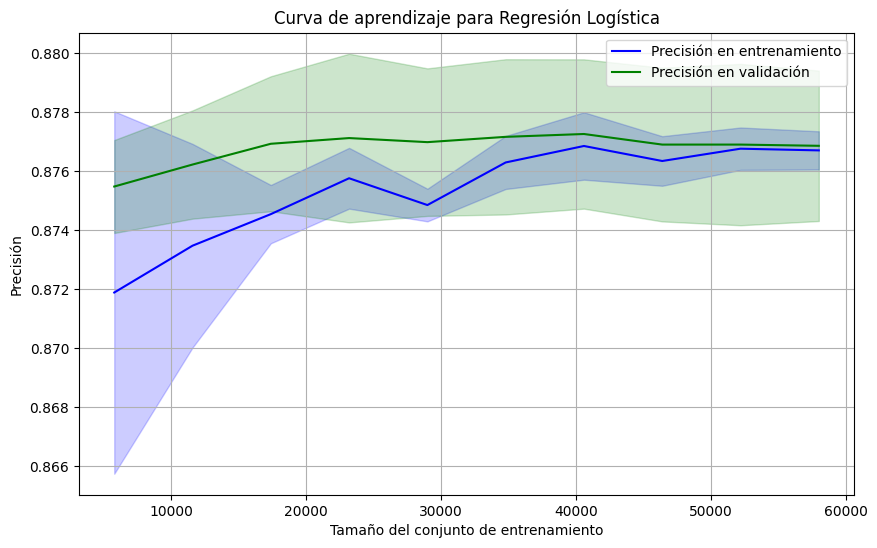

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

# Parámetros para la función learning_curve
train_sizes = np.linspace(0.1, 1.0, 10)  # Fracciones del conjunto de datos de entrenamiento que se usarán

# Generar curva de aprendizaje
train_sizes, train_scores, validation_scores = learning_curve(
    LogisticRegression(), 
    x_train_processed_df, y_train_le, 
    train_sizes=train_sizes, 
    cv=5,  # Validación cruzada de 5 folds
    scoring='accuracy',  # Medimos la precisión del modelo
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Cálculo de la media y desviación estándar para la precisión de entrenamiento y validación
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Precisión en entrenamiento', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.plot(train_sizes, validation_scores_mean, label='Precisión en validación', color='green')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='green', alpha=0.2)

# Etiquetas y leyenda
plt.title('Curva de aprendizaje para Regresión Logística')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.legend(loc='best')

# Mostrar gráfico
plt.grid()
plt.show()


### Puntos importantes sobre la validación cruzada:

Propósito de la validación cruzada:
La validación cruzada es principalmente una técnica de evaluación del modelo, no una métrica en sí misma.

Comparación de validación cruzada con métricas:
* Métricas como accuracy, precisión, recall, F1-score, etc., miden aspectos específicos del rendimiento del modelo.
* La validación cruzada es una metodología para aplicar estas métricas de manera más robusta.



Función principal:
* Evalúa cómo de bien generaliza el modelo a datos no vistos.
* Ayuda a detectar problemas como overfitting o underfitting.
* Proporciona una estimación más confiable del rendimiento esperado del modelo en nuevos datos.

Para evaluar el modelo, la validación cruzada va a entrenar otra vez (aunque el modelo RandomForest ya lo haya hecho). Es decir, complementa, no reemplaza, las métricas tradicionales como accuracy, precisión, recall, etc.
Cómo funciona:
* Divide los datos en varios subconjuntos.
* Entrena el modelo múltiples veces, cada vez con un subconjunto diferente como conjunto de validación, y luego saca una evaluación cada una de las veces.
* Promedia los resultados para obtener una estimación más estable del rendimiento.


Beneficios:
* Uso más eficiente de los datos disponibles para entrenamiento y evaluación.
* Reduce la dependencia de una única división train-test.
* Proporciona una medida de la variabilidad del rendimiento del modelo.


Relación con el entrenamiento:
Aunque no es directamente una forma de entrenar el modelo, la validación cruzada puede informar el proceso de entrenamiento:

Uso de datos en validación cruzada:
Típicamente, la validación cruzada se realiza sobre el conjunto de entrenamiento ('train'), no sobre el conjunto de prueba ('test').


La validación cruzada es una herramienta muy útil para la selección de hiperparámetros. 
* Ayuda a evaluar el rendimiento del modelo con diferentes combinaciones de hiperparámetros.
* Permite una estimación más robusta del rendimiento de cada combinación.
* Reduce el riesgo de overfitting a un conjunto específico de datos de validación.


Proceso de selección de hiperparámetros:

1. Se define un conjunto de valores posibles para cada hiperparámetro.
2. Se prueban diferentes combinaciones de estos valores.
3. Para cada combinación, se realiza validación cruzada.
4. Se elige la combinación que produce el mejor rendimiento promedio en la validación cruzada.

Cómo encuentra los hiperparámetros más adecuados:

* Típicamente, se usa una técnica llamada "búsqueda de cuadrícula" (Grid Search) o "búsqueda aleatoria" (Random Search).
* Cada combinación se evalúa utilizando validación cruzada.
* Se selecciona la combinación con el mejor rendimiento promedio.

Proceso detallado:

Primero, se divide el conjunto de datos original en 'train' y 'test'.
Luego, la validación cruzada se aplica solo al conjunto 'train'.
El conjunto 'test' se mantiene completamente separado y se usa solo para la evaluación final.


Razón de este enfoque:

Preserva la integridad del conjunto de prueba como datos verdaderamente no vistos.
Evita el sobreajuste a los datos de 'test'.

Puntos clave:

La validación cruzada divide y utiliza solo el conjunto de entrenamiento.
El conjunto de prueba permanece intacto y se usa solo para la evaluación final.
Este enfoque proporciona una estimación más realista del rendimiento del modelo en datos nuevos.

Ventajas de este enfoque:

Evita el "data leakage": No utilizamos información del conjunto de prueba durante el entrenamiento o ajuste del modelo.
Proporciona una evaluación más robusta: La validación cruzada da una idea de cómo el modelo se comportará con diferentes subconjuntos de los datos de entrenamiento.
Mantiene la integridad del conjunto de prueba: El conjunto de prueba sigue siendo una representación verdadera de datos no vistos.

## Validación cruzada

4. Preparación de los Algoritmos de ML

5. Seleccionar un modelo y entrénalo

6. Ajustar el modelo (optimización con hypermaprámetros, ensamblado)

7. Presentar la solución.

8. Desplegar y monitorizar